# VGGFace dataset extraction and preparation script

### Dataset Structure Transformation

The data in this dataset is currently structured as follows:

```text
VGGFace/
  ├── 0/
  │    ├── 0.jpg
  │    ├── 1.jpg
  │    ├── 2.jpg
  │    └── ...
  ├── 1/
  │    ├── 315.jpg
  │    ├── 314.jpg
  │    └── ...

we will turn it into:
Images/
  |--1.jpg
  |--2.jpg
  |--3.jpg
  |--...

and a labels.csv file that holds the labels
Data source: https://github.com/deepinsight/insightface/tree/master/recognition/_datasets_

In [14]:
import numpy as np, matplotlib.pyplot as plt
import mxnet as mx
import os
import cv2
import shutil
import pandas as pd

In [3]:
rec_path = os.path.join('..', 'data', 'datasets', 'face recognition', 'VGG-Face', 'faces_vgg_112x112', 'train.rec')
idx_path = os.path.join('..', 'data', 'datasets', 'face recognition', 'VGG-Face', 'faces_vgg_112x112', 'train.idx')
output_dir = os.path.join('..', 'data', 'datasets', 'face recognition', 'VGG-Face', 'aligned')

In [ ]:
os.makedirs(output_dir, exist_ok=True)
record = mx.recordio.MXIndexedRecordIO(idx_path, rec_path, 'r')

In [3]:


for i, key in enumerate(record.keys):
    try:
        header, img = mx.recordio.unpack(record.read_idx(key))
        if isinstance(header.label, list) or isinstance(header.label, np.ndarray):
            label = int(header.label[0])
        else:
            label = int(header.label)
            
        img_arr = cv2.cvtColor(mx.image.imdecode(img).asnumpy(), cv2.COLOR_BGR2RGB)  # Decode to ndarray
        save_dir = os.path.join(output_dir, str(label))
        os.makedirs(save_dir, exist_ok=True)
        
        
        cv2.imwrite(os.path.join(save_dir, f"{i}.jpg"), img_arr)

        if i % 10000 == 0:
            print(f"Processed {i}/{len(record.keys)}")
    except:
        print(i, label)
        continue

Processed 0/3146439
Processed 10000/3146439
Processed 20000/3146439
Processed 30000/3146439
Processed 40000/3146439
Processed 50000/3146439
Processed 60000/3146439
Processed 70000/3146439
Processed 80000/3146439
Processed 90000/3146439
Processed 100000/3146439
Processed 110000/3146439
Processed 120000/3146439
Processed 130000/3146439
Processed 140000/3146439
Processed 150000/3146439
Processed 160000/3146439
Processed 170000/3146439
Processed 180000/3146439
Processed 190000/3146439
Processed 200000/3146439
Processed 210000/3146439
Processed 220000/3146439
Processed 230000/3146439
Processed 240000/3146439
Processed 250000/3146439
Processed 260000/3146439
Processed 270000/3146439
Processed 280000/3146439
Processed 290000/3146439
Processed 300000/3146439
Processed 310000/3146439
Processed 320000/3146439
Processed 330000/3146439
Processed 340000/3146439
Processed 350000/3146439
Processed 360000/3146439
Processed 370000/3146439
Processed 380000/3146439
Processed 390000/3146439
Processed 4000

In [15]:
def sort_jpg_files(files):
    new_files = []
    for file in files:
        image_name = file.split('.')[0]
        new_files.append(int(image_name))
    
    sorted_idx = np.argsort(new_files)
    files = [files[i] for i in sorted_idx]

    return files

In [16]:
db_dir = os.path.split(output_dir)[0]

In [ ]:
length = len(os.listdir(output_dir))
filenames = []
labels = []
for i in range(length):
    for file in sort_jpg_files(os.listdir(os.path.join(output_dir, str(i)))):
        filenames.append(file)
        labels.append(i)

        shutil.move(os.path.join(output_dir, str(i), file), os.path.join(db_dir, 'Images', file))

    os.rmdir(os.path.join(output_dir, str(i)))

labels_df = pd.DataFrame({'filename' : filenames, 'label' : labels})
labels_df.to_csv(os.path.join(db_dir, 'labels.csv'), index = False)

# EDA

In [23]:
labels = pd.read_csv(os.path.join(db_dir, 'labels.csv'))

In [24]:
print(f"Total dataset length: {len(labels)}")

Total dataset length: 3137807


In [25]:
print(f'Total number of classes: {len(labels.label.unique())}')

Total number of classes: 8631


In [26]:
classes, counts = np.unique(labels.label, return_counts = True)
sorted = np.argsort(counts)
counts = counts[sorted]

In [27]:
print(f'Min class Images: {np.min(counts)}')
print(f'Max class Images: {np.max(counts)}')

Min class Images: 87
Max class Images: 840


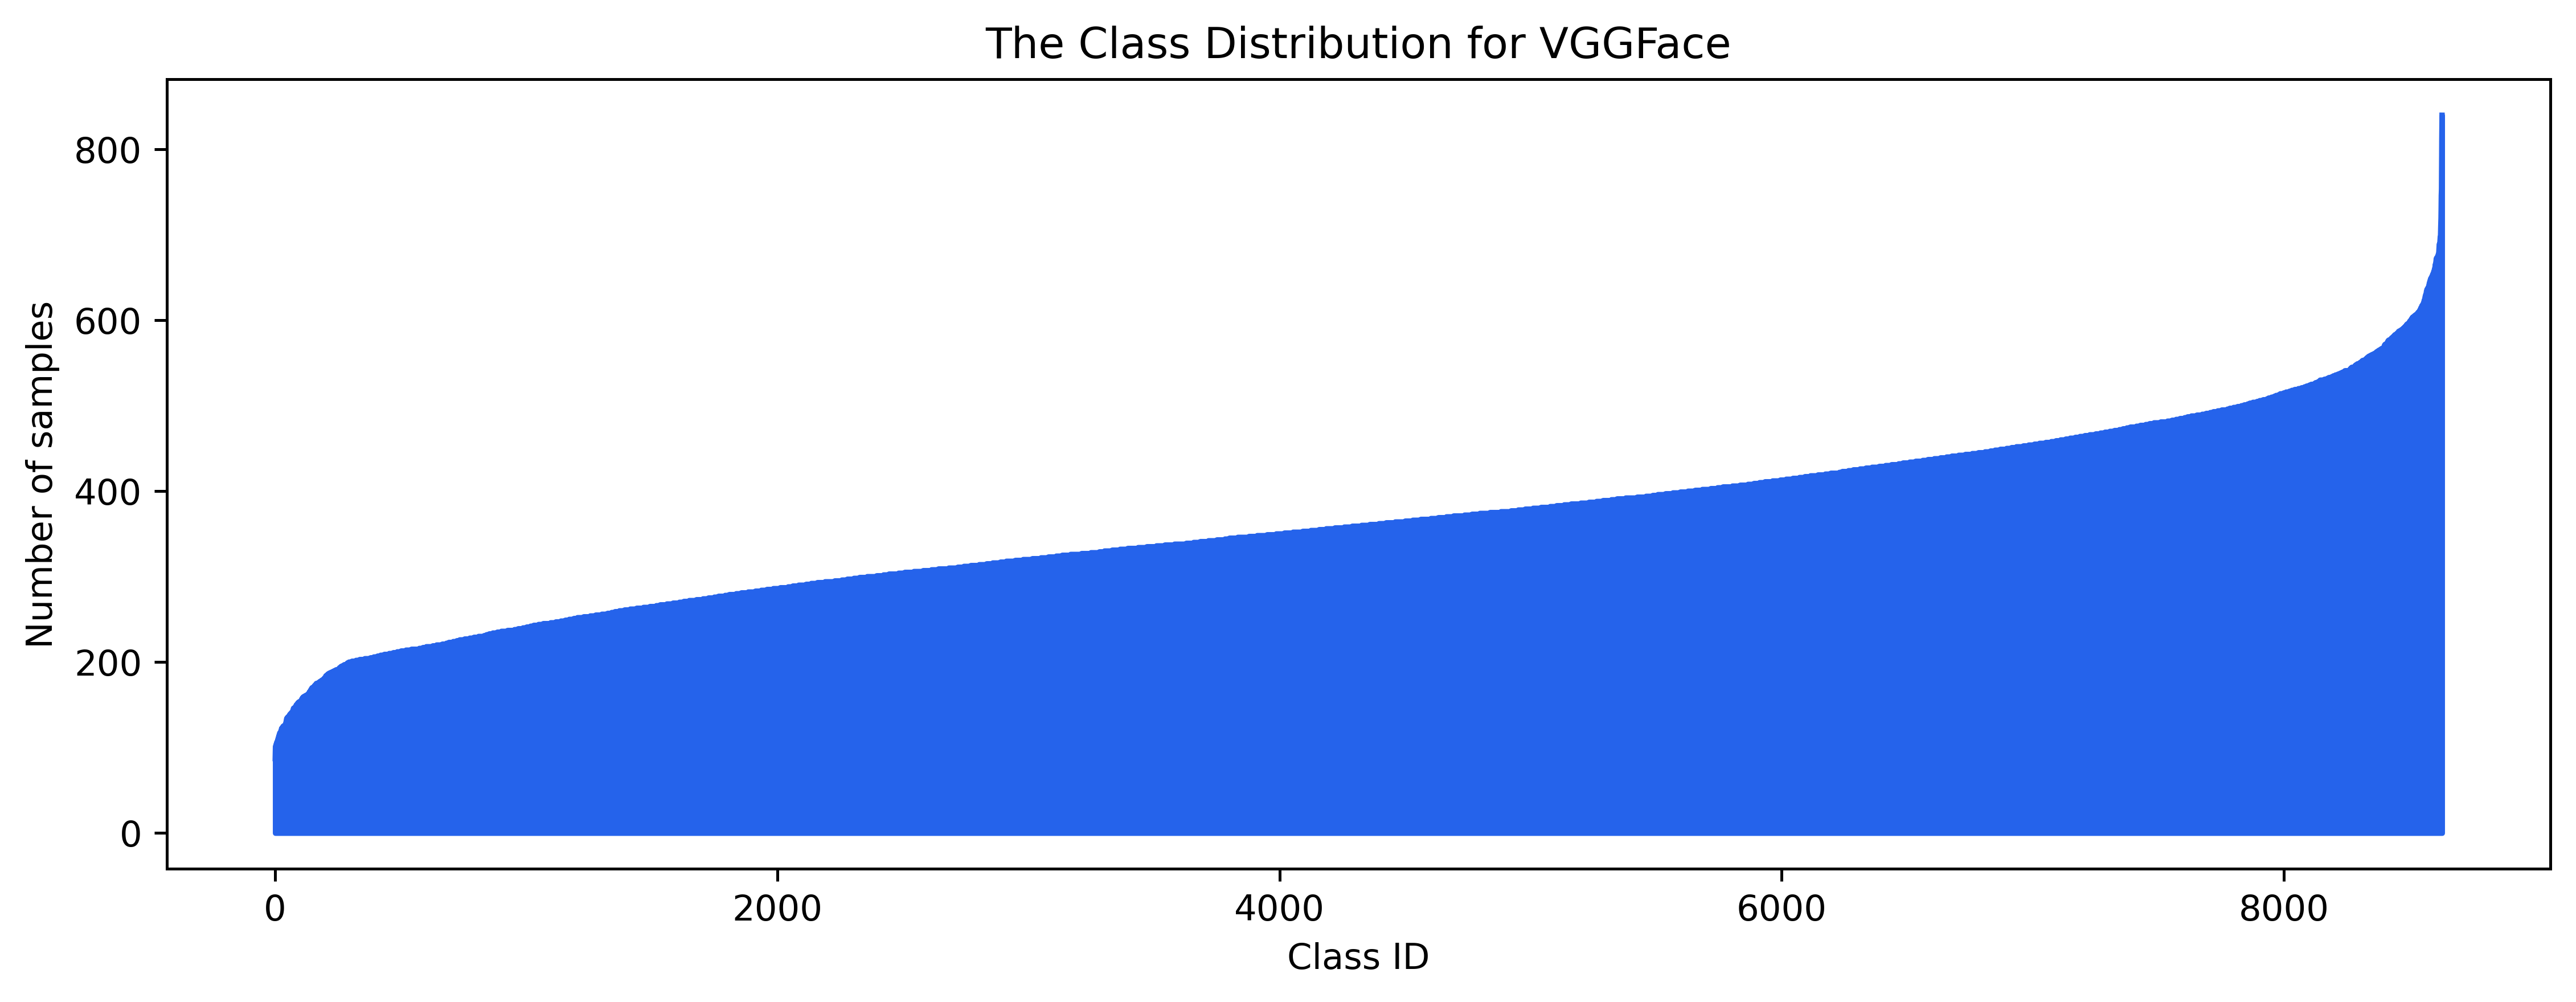

In [28]:
plt.figure(figsize = (12, 4), dpi = 450)
plt.plot(classes, counts, color = "#2563eb")
plt.fill_between(classes, counts, color = "#2563eb", linewidth = 1.5)
plt.title('The Class Distribution for VGGFace')
plt.xlabel('Class ID')
plt.ylabel('Number of samples')
plt.savefig(
    os.path.join('..', 'data', 'figures', 'Face Recognition', 'VGGFace', 'The Class Distribution for VGGFace')
)
plt.show()

In [29]:
sample_images = []
sample_labels = []
for i in range(4): # choose 4 random classes
    class_idx = np.random.randint(low = 0, high = len(labels.label.unique()))
    class_labels = labels[labels['label'] == class_idx]

    while len(class_labels) < 4: # Make sure the chosen class has at least 4 images
            class_idx = np.random.randint(low = 0, high = len(labels.label.unique()))
            class_labels = labels[labels['label'] == class_idx]
            
    indices = []
    for j in range(4): # choose 4 random images within the class
        idx = np.random.randint(low = 0, high = len(class_labels))
        
        while idx in indices: # Make sure the chosen image hasn't been chosen before
            idx = np.random.randint(low = 0, high = len(class_labels))

        filename = class_labels.iloc[idx]['filename']
        label = class_labels.iloc[idx]['label']
        indices.append(idx)
        sample_images.append(filename)
        sample_labels.append(label)

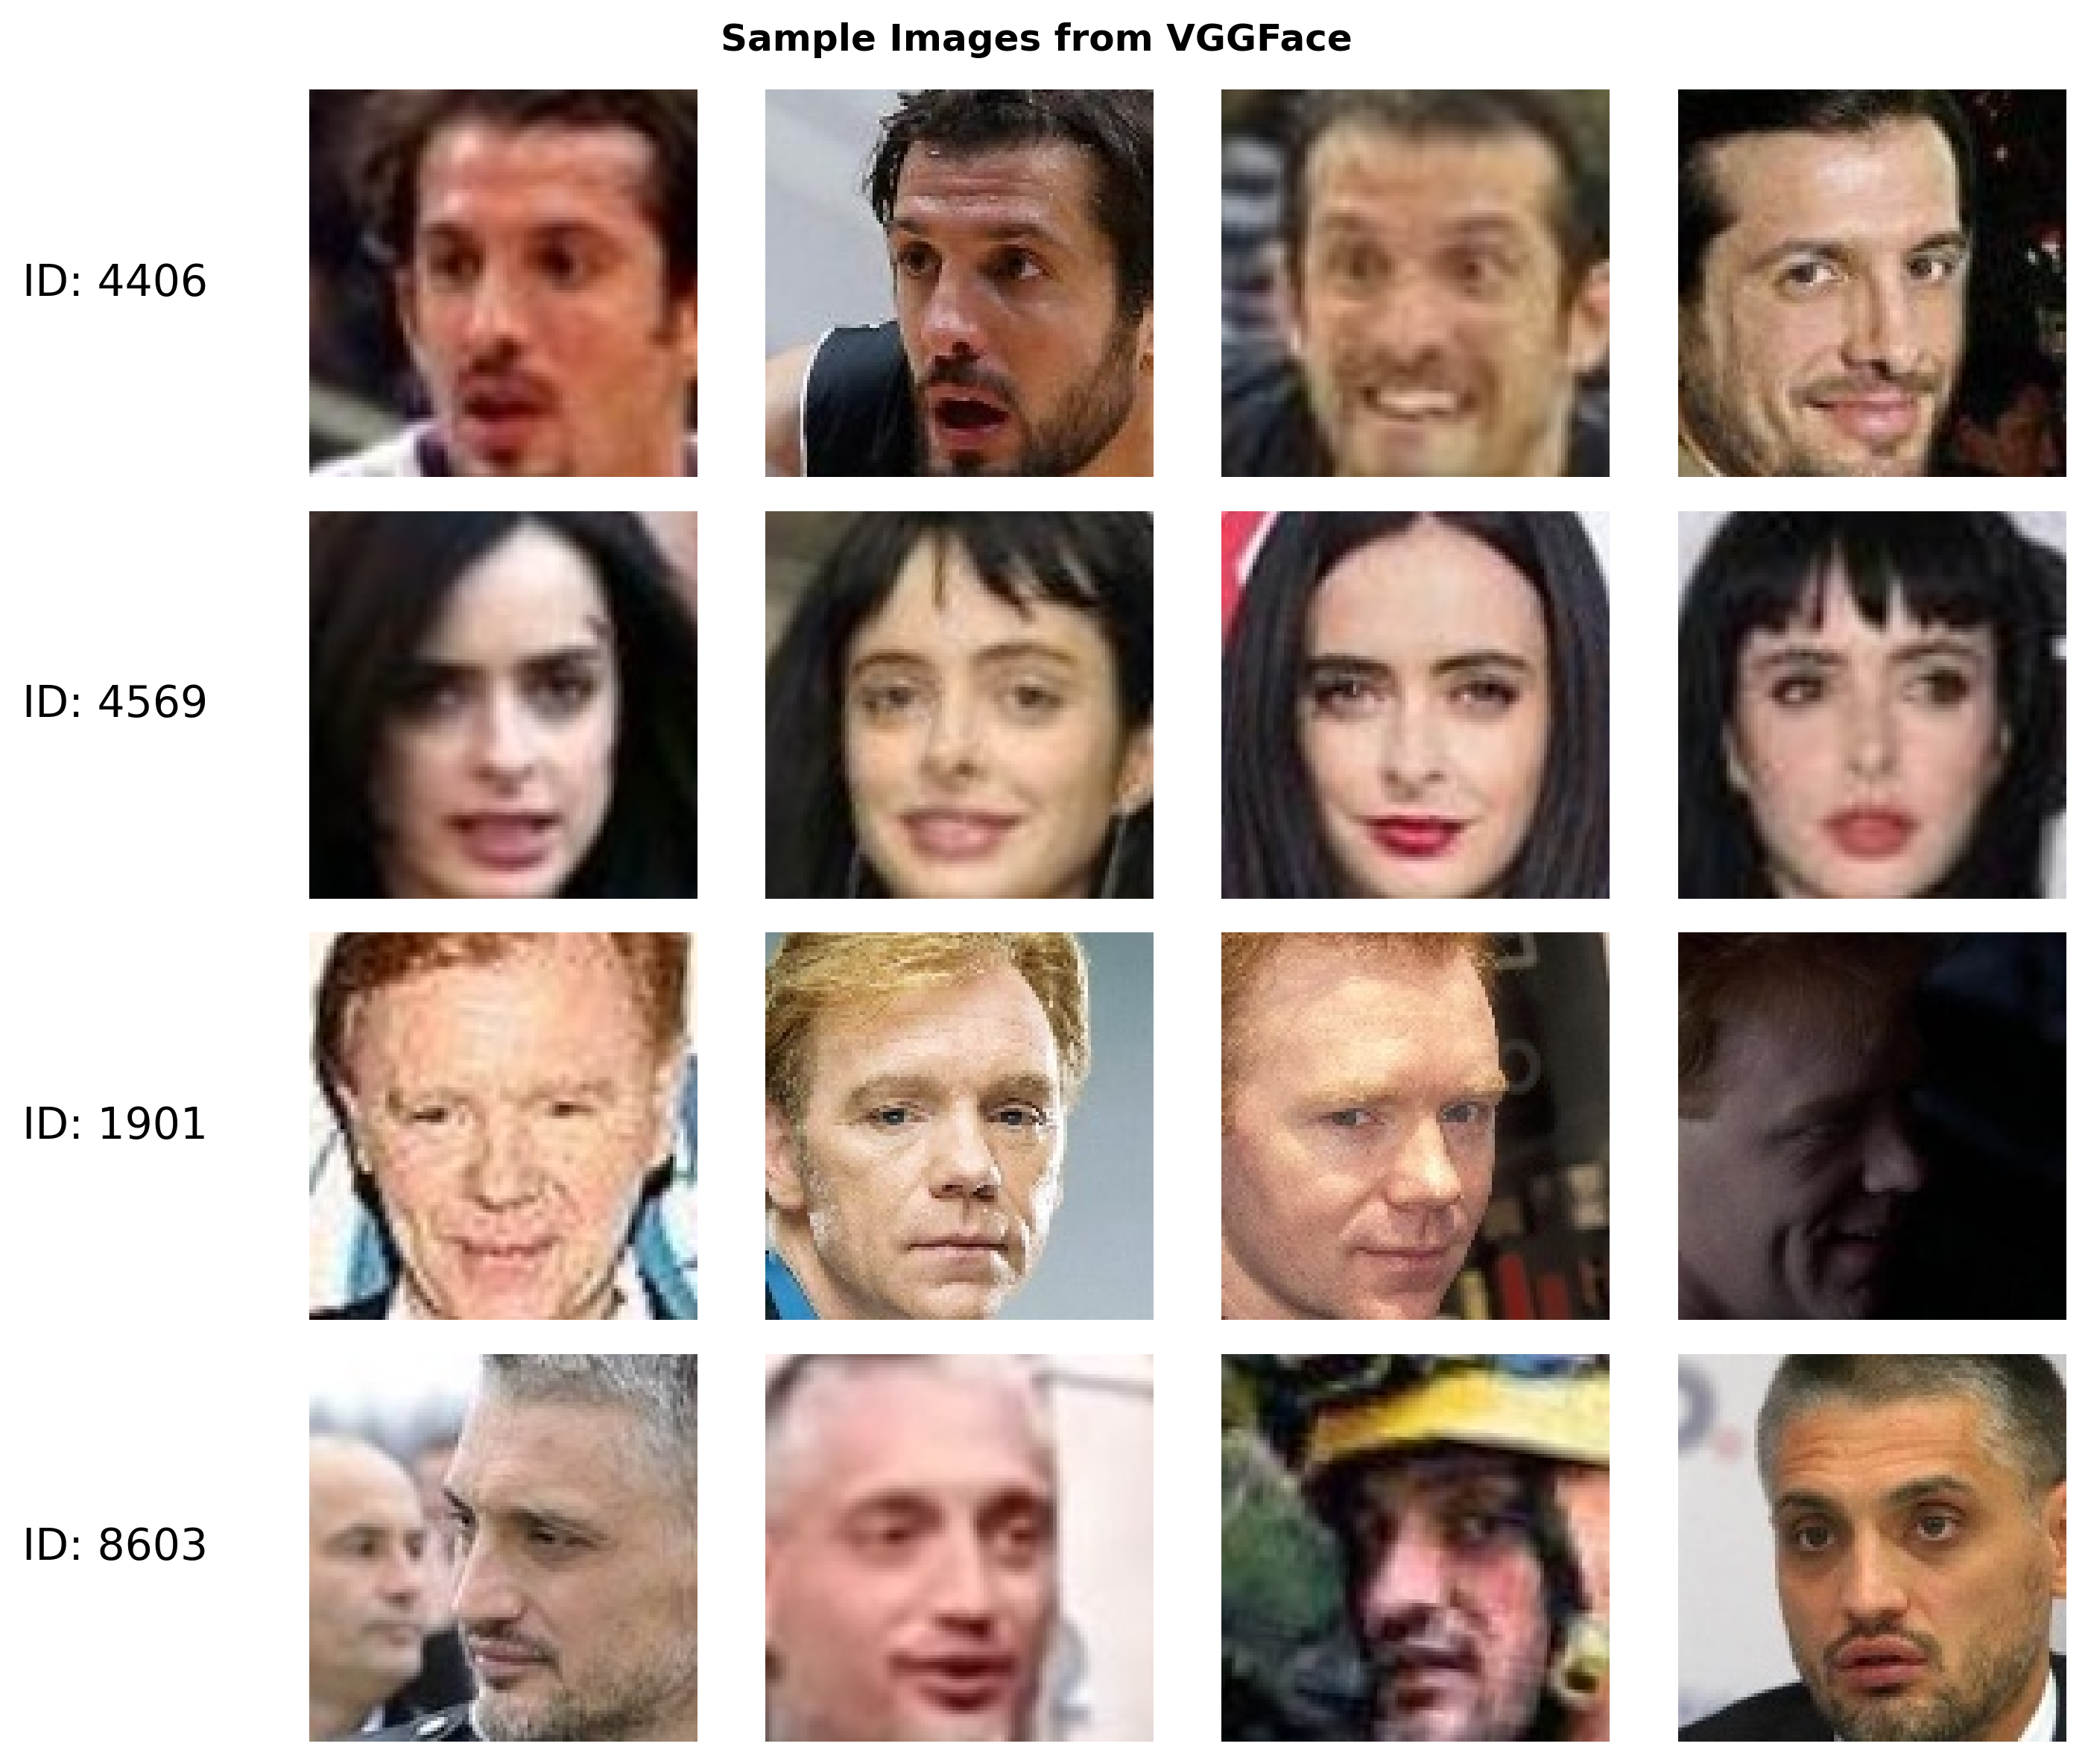

In [30]:
fig, axes = plt.subplots(4, 4, figsize = (10, 8), dpi = 300)
fig.set_dpi(300)
fig.suptitle('Sample Images from VGGFace', fontweight = 'bold')
for i in range(4):
    first_ax = axes[i, 0]

    first_ax.text(
    -0.5, 0.5, f'ID: {sample_labels[i * 4]}',
    transform = first_ax.transAxes,
    va = 'center',
    ha = 'center',
    rotation = 'horizontal',
    fontsize = 14,
    )

    for j in range(4):
        ax = axes[i, j]
        image = plt.imread(os.path.join(db_dir, 'Images', sample_images[i * 4 + j]))
        ax.imshow(image)
        ax.axis('off')
plt.tight_layout()
plt.subplots_adjust(left = 0.15)
plt.savefig(
    os.path.join('..', 'data', 'figures', 'Face Recognition', 'VGGFace', 'Sample Images from VGGFace')
)
plt.show()